In [144]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
# %matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv

import open3d as o3d
from shapely.geometry import LineString

from multiprocessing import Pool
import pca
import RANSAC
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

#### Load Data

In [2]:
# Load data.
tilecode = '2386_9699'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Valeriusplein/pointcloud/processed_' + tilecode + '.laz'
reduced_las_file = '../datasets/Valeriusplein/pointcloud/reduced_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Valeriusplein/ahn/'
# File with BGT building polygons.
bgt_building_file = '../datasets/Valeriusplein/bgt/bgt_buildings.csv'
# File with BGT road polygons.
bgt_road_file = '../datasets/Valeriusplein/bgt/bgt_roads.csv'
# File with <x,y> coordinates of pole-like objects.
bgt_pole_file = '../datasets/Valeriusplein/bgt/custom_poles.csv'
# File with <x,y> coordinates of street furniture objects.
bgt_street_furniture_file = '../datasets/Valeriusplein/bgt/bgt_street_furniture.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

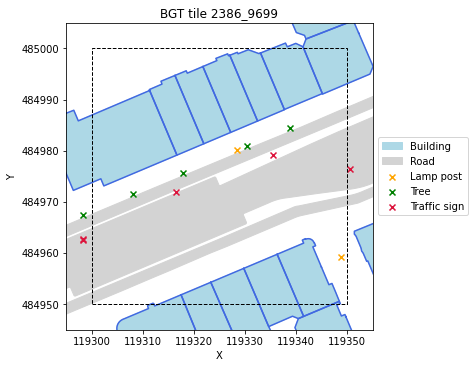

In [3]:
plot_utils.plot_bgt(tilecode, bgt_building_file, bgt_road_file, bgt_pole_file, bgt_street_furniture_file, padding=5)

## Cable Extraction: Feature-based

In [4]:
# true pointcloud
labeled_pointcloud = las_utils.read_las(las_file)
true_labels = labeled_pointcloud.label

# reduced pointcloud
pointcloud = las_utils.read_las(reduced_las_file)
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = pointcloud.label

# mask for unlabelled
mask = np.where(labels == 0)[0]

In [5]:
mask_unlabelled = labels == 0
mask_noise = labels == 99
mask = mask_noise | mask_unlabelled

In [6]:
np.sum(true_labels[mask]==11)

8486

#### Step 1: Neighborhood Selection
Define the neighborhood of a point. Points will be used to calculate point features. (method: voxelization / distance-based / k-NN )

In [7]:
# Voxelization
def voxelize(points, mask, voxel_size, return_voxel_points=False, logger=False):

    # Voxelize point cloud
    cloud = PyntCloud(pd.DataFrame(points[mask,:], columns=['x','y','z']))
    voxelgrid_id = cloud.add_structure("voxelgrid", size_x=voxel_size, size_y=voxel_size, size_z=voxel_size, regular_bounding_box=False)
    voxel_grid = cloud.structures[voxelgrid_id]
    if logger:
        print('Voxels per axis:',voxel_grid.x_y_z)
        print('Voxel size:',voxel_grid.shape)

    # Group points per voxel 
    if return_voxel_points:
        pv_table = np.vstack([voxel_grid.voxel_n, np.arange(0,voxel_grid.voxel_n.shape[0])]).T
        pv_table = pv_table[pv_table[:, 0].argsort()]
        voxel_idx, voxel_idx_index = np.unique(pv_table[:, 0], return_index=True)
        voxel_points = np.split(pv_table[:, 1], voxel_idx_index[1:])

        return voxel_grid, voxel_points, voxel_idx
    
    return voxel_grid

In [8]:
def multi_proc_eig(covariances):
    # Alternative: tqdm process_map(np.linalg.eig, covariances)
    with Pool() as pool:
        return pool.map(pca.eig, covariances)

In [9]:
# Parameters
def pc_pca(points, mask, method='radius', knn=30, radius=1, voxel_size=1):

    if method == 'knn':
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[mask])
        pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=knn))
        covariances = np.asarray(pcd.covariances)
        eig_val_vec = multi_proc_eig(covariances)

    elif method == 'radius':
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points[mask])
        pcd.estimate_covariances(search_param=o3d.geometry.KDTreeSearchParamRadius(radius=radius))
        covariances = np.asarray(pcd.covariances)
        eig_val_vec = multi_proc_eig(covariances)

    elif method == 'voxel':
        voxel_grid, voxel_point_idx, voxel_idx = voxelize(points, mask, voxel_size=voxel_size, return_voxel_points=True)
        voxel_table = {k: v for v, k in enumerate(voxel_idx)}
        covariances = [np.cov(points[mask][idx], rowvar=False) for idx in voxel_point_idx]
        voxel_eig_val_vec = multi_proc_eig(covariances)
        eig_val_vec = [voxel_eig_val_vec[voxel_table[voxel_id]] for voxel_id in voxel_grid.voxel_n]
    
    return eig_val_vec

In [10]:
eig_val_vec = pc_pca(points, mask, method='radius', radius=1)

#### Step 2: Cadidate Cable Points
Use PCA to calculate geometrical features of a point and assess linearity.

In [11]:
assert len(eig_val_vec) == len(points[mask])

eps_1 = 0.001
eps_2 = 0.1
candidate_mask = np.zeros(len(points[mask]), dtype=bool)
for i in range(len(eig_val_vec)):
    eig_val = eig_val_vec[i][0]
    if eig_val is not None:

        # Sort eigenvalues λ1 > λ2 > λ3
        idx = eig_val.argsort()[::-1]   
        eig_val = eig_val[idx]

        # Linearity Check
        if (abs(eig_val[1]-eig_val[2]) < eps_1) and eig_val[0] > eig_val[1] + eps_2:
            candidate_mask[i] = True


In [12]:
print('Guessed:',np.sum(candidate_mask))
print('Missed:',np.sum(true_labels[mask]==11) - np.sum(true_labels[mask][candidate_mask]==11))

Guessed: 6335
Missed: 2183


##### Labelled cable PCA Analysis

In [8]:
def pca_method_comp(eig_val_vec, true_labels, mask, plotting=False):
    cable_idx = np.where(true_labels[mask]==11)[0]

    results_cable = []
    results_non_cable = []
    for i in range(len(eig_val_vec)):
        eig_val = eig_val_vec[i][0]
        if eig_val is not None:
            idx = eig_val.argsort()[::-1]   
            eig_val = eig_val[idx]
            if i in cable_idx:
                results_cable.append([round(eig_val[0],4),round(abs(eig_val[0]-eig_val[1]),4),round(abs(eig_val[1]-eig_val[2]),4)])
            else:
                results_non_cable.append([round(eig_val[0],4),round(abs(eig_val[0]-eig_val[1]),4),round(abs(eig_val[1]-eig_val[2]),4)])
        else:
            if i in cable_idx:
                results_cable.append([np.nan,np.nan,np.nan])
            else:
                results_non_cable.append([np.nan,np.nan,np.nan])

    df_results_cable = pd.DataFrame(results_cable, columns=['λ1','λ1-λ2','λ2-λ3'])
    df_results_non_cable = pd.DataFrame(results_non_cable, columns=['λ1','λ1-λ2','λ2-λ3'])
    df_results_non_cable = df_results_non_cable[df_results_non_cable['λ1'] < 1]

    if plotting:
        fig, ax = plt.subplots(1)
        df_results_cable.plot.scatter(x='λ1-λ2', y='λ2-λ3', s=0.1, alpha=0.5, ax=ax)
        df_results_non_cable.plot.scatter(x='λ1-λ2', y='λ2-λ3', c='r', s=0.1, alpha=0.5, ax=ax)

    return df_results_cable, df_results_non_cable

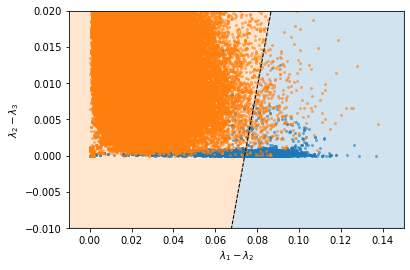

In [98]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

eig_val_vec = pc_pca(points, mask, method='radius', voxel_size=1.5)
df_a, df_b = pca_method_comp(eig_val_vec, true_labels, mask)

# Logistic Regregession Guess
x_a = df_a.dropna().values[:,1:]
x_b = df_b.dropna().values[:,1:]
X = np.vstack([x_a,x_b])
y = np.ones(len(X))
y[len(x_a):] = 0

clf = LogisticRegression(random_state=0).fit(X, y)
cable_gueses = np.where(clf.predict(X)==1)[0]
np.sum(y[cable_gueses]==1)/len(cable_gueses), np.sum(y[cable_gueses]==1), np.sum(y==1)

b = clf.intercept_[0]
w1, w2 = clf.coef_.T

c = -b/w2
m = -w1/w2

xmin, xmax = -0.01, 0.6
ymin, ymax = -0.01, 0.3
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X[:len(x_a)].T, s=4, alpha=0.5)
plt.scatter(*X[len(x_a):].T, s=4, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$λ_2-λ_3$')
plt.xlabel(r'$λ_1-λ_2$')

plt.show()


In [61]:
def comparison_analysis(points, mask, method, radius=1, knn=30, voxel_size=1):

    eig_val_vec = pc_pca(points, mask, method=method, radius=radius, knn=knn, voxel_size=voxel_size)
    df_a, df_b = pca_method_comp(eig_val_vec, true_labels, mask)

    # Logistic Regregession Guess
    x_a = df_a.values[:,1:]
    x_b = df_b.values[:,1:]
    X = np.vstack([x_a,x_b])
    y = np.ones(len(X))
    y[len(x_a):] = 0

    scores = []
    for x1 in np.arange(0.1,0.3,0.01):
        for x2 in np.arange(0.0006,0.0024,0.0002):
            cable_gueses = np.where((X[:,0] > x1) & (X[:,1] < x2))[0]
            if len(cable_gueses) > 0:
                score = round(np.sum(y[cable_gueses]==1)/len(cable_gueses),2)
                qt = np.sum(y[cable_gueses]==1)
                scores.append([x1,x2,score,qt])

    df = pd.DataFrame(scores, columns=['x1','x2','acc','qty'])
    return df[df.qty>3000].sort_values(['acc','qty'], ascending=False)[:10], X, y


In [62]:
for r in [1]:
    start=time.time()
    results = comparison_analysis(points, mask, method='radius', radius=r)[0]
    duration=time.time()-start
    print(f'Method RADIUS with r={r} ({round(duration,2)}s)')
    display(results)


Method RADIUS with r=1 (18.31s)


,x1,x2,acc,qty
2,0.10,0.0010,1.0,6192
12,0.11,0.0012,1.0,6165
11,0.11,0.0010,1.0,6144
1,0.10,0.0008,1.0,6126
21,0.12,0.0012,1.0,6117
20,0.12,0.0010,1.0,6096
10,0.11,0.0008,1.0,6078
31,0.13,0.0014,1.0,6077
43,0.14,0.0020,1.0,6074
42,0.14,0.0018,1.0,6071


In [63]:
_, X, y = comparison_analysis(points, mask, method='radius', radius=1)
xmin = 0.1
ymax = 0.001

# to pts
cable_idx = np.where(true_labels[mask]==11)[0]
non_cable_idx = np.where(true_labels[mask]!=11)[0]

cable_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] > xmin) & (X[:len(cable_idx),1] < ymax))[0]]]
cable_n_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] <= xmin) | (X[:len(cable_idx),1] >= ymax))[0]]]
n_cable_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] > xmin) & (X[len(cable_idx):,1] < ymax))[0]]]
#n_cable_n_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] <= xmin) | (X[len(cable_idx):,1] >= ymax))[0]]]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(cable_lin[:, 0], cable_lin[:, 1], cable_lin[:, 2], s=2, color='tab:red', label='Cable (Linear)')
ax.scatter(cable_n_lin[:, 0], cable_n_lin[:, 1], cable_n_lin[:, 2], s=0.25, color='tab:green', alpha=0.25, label='Cable (Non-Linear)')
ax.scatter(n_cable_lin[:, 0], n_cable_lin[:, 1], n_cable_lin[:, 2], s=1, color='tab:blue', label='Non Cable (Linear)')
ax.set_zlim((0,12))
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [140]:
X, y = comparison_analysis(points, mask, method='radius', radius=1.5)
xmin = 0.21
ymax = 0.0008

# to pts
cable_idx = np.where(true_labels[mask]==11)[0]
non_cable_idx = np.where(true_labels[mask]!=11)[0]

cable_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] > xmin) & (X[:len(cable_idx),1] < ymax))[0]]]
cable_n_lin = points[mask][cable_idx[np.where((X[:len(cable_idx),0] <= xmin) | (X[:len(cable_idx),1] >= ymax))[0]]]
n_cable_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] > xmin) & (X[len(cable_idx):,1] < ymax))[0]]]
n_cable_n_lin = points[mask][non_cable_idx[np.where((X[len(cable_idx):,0] <= xmin) | (X[len(cable_idx):,1] >= ymax))[0]]]

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(cable_lin[:, 0], cable_lin[:, 1], cable_lin[:, 2], s=1, color='tab:blue', label='Cable (Linear)')
ax.scatter(cable_n_lin[:, 0], cable_n_lin[:, 1], cable_n_lin[:, 2], s=0.5, color='tab:grey', alpha=0.5, label='Cable (Non-Linear)')
ax.scatter(n_cable_lin[:, 0], n_cable_lin[:, 1], n_cable_lin[:, 2], s=1, color='tab:red', label='Non Cable (Linear)')

ax.set_zlim((0,12))
plt.legend()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

#### Step 3: Cluster Cable Points
Use euclidean distance clustering to cluster candidate cable points. (params: distance threshold)

In [244]:
cable_mask = candidate_mask.copy()

# Cluster the potential seed points.
clustering = (DBSCAN(eps=.75, min_samples=4, p=2).fit(points[mask][cable_mask]))
cluster_labels, counts = np.unique(clustering.labels_, return_counts=True) # Get cluster labels and sizes.
min_points = 4

if min_points > 1:
    # Only keep clusters with size at least min_points.
    cluster_labels = cluster_labels[counts >= min_points]

# Create cable cluster labels
cc_labels = np.zeros(len(cable_mask))
for cl in set(cluster_labels).difference((-1,)):
    c_mask = clustering.labels_ == cl
    cc_labels[np.where(cable_mask)[0][c_mask]] = cl+1

# Update cable mask and labels
cluster_labels, counts = np.unique(clustering.labels_, return_counts=True)
cable_mask[cc_labels == 0] = False

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# for cl in set(cc_labels).difference((0,)):
#     cluster_mask = cc_labels == cl
#     ax.scatter(points[mask][cluster_mask][:,0],points[mask][cluster_mask][:,1],points[mask][cluster_mask][:,2], s=4, label=str(cl))
# ax.set_zlim((0,12))
# plt.show()


In [ ]:
# for cl in set(cc_labels).difference((-1,)):
#     c_mask = clustering.labels_ == cl

#     # Mean Height
#     mean_z = np.mean(candidate_cable_pts[c_mask][:,2])
    
#     # Main Direction
#     cov = np.cov(candidate_cable_pts[c_mask], rowvar=False)
#     eig_val, eig_vec = np.linalg.eig(cov)
#     dir_v = eig_vec[eig_val.argmax()]

#     # Catenary fit
#     catenary_model = RANSAC.Line()
#     catenary_params, _, _ = catenary_model.fit(candidate_cable_pts[c_mask], max_trials=100)

#     print(cl, 'Height:',round(mean_z,2), '\tPCA1:',np.round(dir_v,2), '\tCatenary:', np.round(catenary_params,3))

#### Step 4: Merge cable segments
Use cable segment properties to determine if cable segments belong to the same cable. Features which can be used: direction, height, and catenary fit.

In [230]:
def grow_cable_section(points, cable_mask, unclassified_mask, buffer=0.5):

    no_added = 0

    # 3D-section direction
    section_dir = main_direction(points[cable_mask])

    # 3D-section centroid
    section_vals = np.dot(points[cable_mask,:2], section_dir[:2])
    i_min, i_max = section_vals.argmin(), section_vals.argmax()
    section_centroid = np.mean(points[cable_mask][[i_min,i_max]], axis=0)
    
    # 3D-section search neighborhood
    search_area = math_utils.convex_hull_poly(points[cable_mask]).buffer(buffer)
    candidate_mask = clip_utils.poly_clip(points[unclassified_mask], search_area) # error MultiPolygon
    candidate_idx = np.where(unclassified_mask)[0][candidate_mask]

    # Condition candidate points
    if len(candidate_idx):
        for idx in candidate_idx:

            # Get query point
            query_point = points[idx]

            # Calculate angle
            query_vec = query_point - section_centroid
            angle = angle_between(section_dir, query_vec)

            # compare angle
            if angle < 5:
                cable_mask[idx] = True 
                unclassified_mask[idx] = False
                no_added += 1

    return cable_mask, unclassified_mask


In [241]:
def cable_growing(points, cable_mask, unclassified_mask, angle_threshold=5):

    cable_points = points[cable_mask]
    unclassified_points = points[unclassified_mask]
    label_mask = np.zeros(len(points),dtype=bool)

    if len(cable_points[:,:2]) > 4:

        # Split cable in head and tail sections
        section_length = 2 # meters
        cable_dir = main_direction(cable_points[:,:2]) # condition
        line_value = np.dot(cable_points[:,:2], cable_dir)

        # Grow sections
        head_segment_mask = np.zeros(len(cable_mask),dtype=bool)
        head_segment_mask[cable_mask] = line_value > line_value.max() - section_length
        head_segment_mask, unclassified_mask = grow_cable_section(points, head_segment_mask, unclassified_mask)

        tail_segment_mask = np.zeros(len(cable_mask),dtype=bool)
        tail_segment_mask[cable_mask] = line_value < line_value.min() + section_length
        tail_segment_mask, unclassified_mask = grow_cable_section(points, tail_segment_mask, unclassified_mask)

        grow_mask = head_segment_mask | tail_segment_mask
        cable_mask = cable_mask | grow_mask

    return cable_mask, unclassified_mask


In [245]:

labels_sorted = cluster_labels[counts.argsort()[::-1]]
for cl_label in labels_sorted:
    if cl_label != 0:
        print(cl_label)
        cl_mask = cc_labels == cl_label
        unclassified_mask = cc_labels == 0

        condition = True
        while condition:
            n_pts = np.sum(cl_mask)
            cl_mask, unclassified_mask = cable_growing(points[mask], cl_mask, unclassified_mask, angle_threshold=5)
            condition = np.sum(cl_mask) > n_pts 

        cc_labels[unclassified_mask] = 0
        cc_labels[cl_mask] = cl_label
        

8
7
5
9
3
6
4
12
2
13
10
17
15
19
11
1
-1
18
16


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [239]:
fig = plt.figure()
ax = plt.axes(projection='3d')
for cl in set(cc_labels).difference((0,)):
    cluster_mask = cc_labels == cl
    ax.scatter(points[mask][cluster_mask][:,0],points[mask][cluster_mask][:,1],points[mask][cluster_mask][:,2], s=1, label=str(cl))
ax.set_zlim((0,12))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

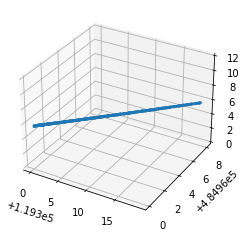

In [35]:
c_mask = clustering.labels_ == 9
segment_points = candidate_cable_pts[c_mask]

# Main Direction
cov = np.cov(segment_points, rowvar=False)
eig_val, eig_vec = np.linalg.eig(cov)
dir_v = eig_vec[eig_val.argmax()]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(segment_points[:,0],segment_points[:,1],segment_points[:,2], s=4)
ax.set_zlim((0,12))
plt.show()


In [43]:
unclassified_pts = points[mask][~candidate_mask]

In [121]:
def main_direction(points):
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    return eig_vec[:,eig_val.argmax()]

In [157]:
# Calculate cable direction
cable_dir = main_direction(segment_points[:,:2])

line_value = np.dot(segment_points[:,:2], cable_dir)
end_threshold_m = 2 # meters
A_segment_mask = line_value > line_value.max() - end_threshold_m
B_segment_mask = line_value < line_value.min() + end_threshold_m

# 1. Grow in direction (A)
A_segment_points = segment_points[A_segment_mask]
A_segment_centroid = np.mean([A_segment_points[line_value[A_segment_mask].argmax()], A_segment_points[line_value[A_segment_mask].argmin()]], axis=0)
A_segment_dir = main_direction(A_segment_points)
search_area = math_utils.convex_hull_poly(A_segment_points).buffer(.5)
candidate_unclassified_mask = clip_utils.poly_clip(points[mask][~candidate_mask], search_area)

valid_pts = []
unvlaid_pts = []
for p_k in points[mask][~candidate_mask][candidate_unclassified_mask]:
    
    # Anngle condition
    Vp_k = p_k - A_segment_centroid
    angle_diff = angle_between(A_segment_dir,Vp_k)

    # height condition
    # hieght_diff = p_k[2] - A_segment_points[:,2].mean() 
    
    if angle_diff < 5:# and hieght_diff < 0.05:
        valid_pts.append(p_k)
    else:
        unvlaid_pts.append(p_k)

valid_pts = np.array(valid_pts)
unvlaid_pts = np.array(unvlaid_pts)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(A_segment_points[:,0],A_segment_points[:,1],A_segment_points[:,2], s=4)
if len(valid_pts) > 0:
    ax.scatter(valid_pts[:,0],valid_pts[:,1],valid_pts[:,2], s=1)
if len(unvlaid_pts) > 0:
    ax.scatter(unvlaid_pts[:,0],unvlaid_pts[:,1],unvlaid_pts[:,2], s=1)
ax.set_zlim((5,6))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

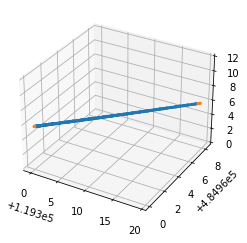

In [44]:
search_area = math_utils.convex_hull_poly(segment_points).buffer(0.5)
cc_growing_mask = clip_utils.poly_clip(points[mask][~candidate_mask], search_area)
cc_growing_mask

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(segment_points[:,0],segment_points[:,1],segment_points[:,2], s=4)
ax.scatter(unclassified_pts[cc_growing_mask][:,0],unclassified_pts[cc_growing_mask][:,1],unclassified_pts[cc_growing_mask][:,2], s=4)
ax.set_zlim((0,12))
plt.show()


In [57]:
V_p_k, dir_v[:2]

([9.642621371676796, 4.054134333622642], array([ 0.92172368, -0.38079784]))

In [87]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

Height difference: 0.03240963855421608 (5.79,5.757590361445784)
Direction difference: 0.014027873881933824


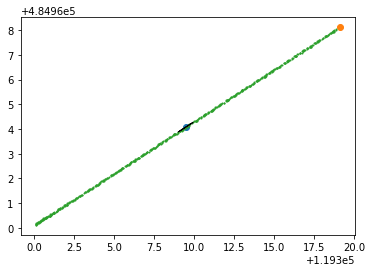

In [120]:
p_ks = unclassified_pts[cc_growing_mask]
for p_k in p_ks:
    cov = np.cov(segment_points[:,:2], rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    V_p_k = [p_k[0]-search_area.centroid.x,p_k[1]-search_area.centroid.y]
    angle = angle_between(dir_v,V_p_k)



    print(f'Height difference: {abs(p_k[2]-segment_points[end_segment_mask,2].mean())} ({p_k[2]},{segment_points[end_segment_mask,2].mean()})')
    print(f'Direction difference: {angle}')

    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(search_area.centroid.x,search_area.centroid.y)
    ax.arrow(segment_points[:,0].mean(),segment_points[:,1].mean(), dir_v[0], dir_v[1])
    ax.scatter(p_k[0],p_k[1])
    ax.scatter(segment_points[:,0],segment_points[:,1], s=1)
    plt.show()
    break

In [118]:
line_value = np.dot(segment_points[:,:2], dir_v)
end_segment_idx = np.where(line_value > line_value.max() - 2)[0] # 2 meter
start_segment_idx = np.where(line_value < line_value.min() + 2)[0]

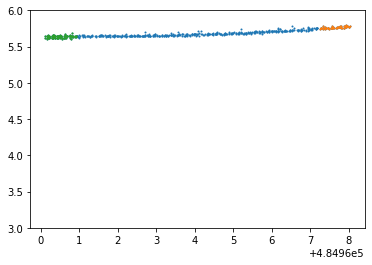

In [119]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(segment_points[:,1],segment_points[:,2], s=1)
ax.scatter(segment_points[end_segment_idx,1],segment_points[end_segment_idx,2], s=1)
ax.scatter(segment_points[start_segment_idx,1],segment_points[start_segment_idx,2], s=1)
ax.set_ylim(3,6)
plt.show()

In [93]:
segment_points[162,2], segment_points

5.79

In [83]:
cov = np.cov(segment_points[:,:2], rowvar=False)
np.linalg.eig(cov)[1][:,0]

array([0.92174263, 0.38780217])

In [78]:
scipy.linalg.eig(cov)

(array([3.73572617e+01+0.j, 1.89483221e-04+0.j]),
 array([[ 0.92174263, -0.38780217],
        [ 0.38780217,  0.92174263]]))

In [77]:
import scipy

In [36]:
dir_v
#math_utils.vector_angle()

array([ 0.92172368, -0.38079784,  0.07361017])

In [ ]:
labels[np.where(mask)[0][candidate_mask]] = 11
print((labels==11).sum() )
#out_file = '../datasets/Valeriusplein/pointcloud/exp_B_' + tilecode + '.laz'
#las_utils.label_and_save_las(pointcloud, labels, out_file)